# 1. Como executar
Para executar esse notebook com CPU ou GPU siga os passos abaixo:

Caso esteja rodando localmente execute o comando pip install -r requirements.txt para download de todas as dependências necessárias e vá para o passo 4.

1. Baixe este notebook e importe para o Google Colab

2. No menu superior direito do colab, onde está escrito "Conectar" ou "Ligar", clique na seta ao lado e escolha a opção "Alterar o tipo de ambiente de execução"

3. Uma janela será aberta onde você pode escolher entre utilizar CPU ou GPU. Escolha a que deseja utilizar (caso esteja em uma conta gratuita, apenas CPU e a T4 GPU estarão disponíveis). Clique em "OK" caso um pop-up apareça. Dica: GPUs são mais rápidas.

4. Execute a seção Importação de dependências para baixar todas as dependências necessárias.

Pronto! Já está tudo preparado para execução.

<strong>OBS: Caso deseje alterar de CPU para GPU, ou vice-versa, durante a execução, a sessão será reiniciada e tudo deverá ser executado novamente.</strong>

# 2. Configurações iniciais - importação das bibliotecas necessárias e do dataset pré-processado

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install imbalanced-learn

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import gensim
import os
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorboard.plugins import projector
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
import time
import json
import psutil
import seaborn as sns

In [5]:
# Carregar o dataset pré-processado
df = pd.read_csv('/content/drive/MyDrive/Dados/Dados_processados.csv')

# Remover embeddings gerados anteriormente
df = df.drop(columns=['perguntas_embedding', 'respostas_embedding'])

df.head(3)

,Intencao,Pergunta,Resposta,processed_pergunta,processed_resposta
0,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d...","['dia', 'gostar', 'caixa', 'family', 'Mart', '...","['dia', 'sr', 'utilizar', 'cartão', 'depósito'..."
1,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f...","['enviar', 'dinheiro', 'Japão']","['inscrever', 'serviço', 'remesso', 'baixe', '..."
2,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ...","['levar', 'beneficiário', 'receber', 'dinheiro']","['via', 'regro', 'remessa', 'ser', 'pago', 'vi..."


# 3. Definição de função de vetorização Word2Vec e seus respectivos testes

Obtivemos um modelo pré-treinado do Word2Vec de NLU para a língua portuguesa no site a seguir: http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc.

Vamos usar esse modelo para realizar os embeddings das palavras, que alimentarão posteriormente uma rede neural para classificação de intenções.

## 3.1. Download do modelo Word2Vec (w2v)

In [6]:
!wget http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip

--2024-08-30 01:52:05--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/octet-stream]
Saving to: ‘download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip’

download.php?file=e 100%[===================>] 914.21M  11.2MB/s    in 83s     

2024-08-30 01:53:27 (11.1 MB/s) - ‘download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip’ saved [958619745/958619745]



In [7]:
!unzip /content/download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip

Archive:  /content/download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip
  inflating: skip_s300.txt           


## 3.2. Carregar o modelo Word2Vec na memória do notebook e o dataset pré-processado

In [8]:
model_path = "skip_s300.txt"
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

## 3.3. Converter o texto em um vetor de embeddings usando o modelo W2V

In [9]:
def vectorize_text(model, tokens):
    """
    Converte uma lista de tokens em um vetor de embeddings utilizando um modelo de word embeddings.

    A função percorre cada token na lista fornecida e, se o token existir no modelo de embeddings,
    o valor correspondente ao token é adicionado a um vetor acumulador. No final, o vetor acumulador
    é normalizado pela quantidade de tokens encontrados no modelo, resultando em um vetor médio.

    :param gensim.models.KeyedVectors model: O modelo de embeddings pré-treinado que mapeia tokens para vetores de embeddings.
    :param list of str tokens: Lista de tokens (palavras) a serem convertidos em um vetor de embeddings.

    :return : Um vetor normalizado que é a média dos vetores dos tokens encontrados no modelo. Se nenhum token for encontrado, retorna um vetor de zeros.
    :rtype: np.ndarray
    """
    vector = np.zeros(model.vector_size)  # Inicializar um vetor com "0"s com o tamanho de dimensões do modelo w2v
    count = 0
    for token in tokens:
        if token in model:  # Adicionar o valor dos tokens do modelo no vetor "acumulador"
            vector += model[token]
            count += 1
    if count > 0:
        vector /= count  # Normalizar o vetor "acumulador"
    return vector

In [10]:
# Aplicar vetorização às questões pré-processadas
df['vector_pergunta'] = df['processed_pergunta'].apply(lambda x: vectorize_text(model, x))
df['vector_pergunta'].head()

,vector_pergunta
0,"[-0.1063040602361647, 0.036021842155605555, -0..."
1,"[-0.07543596465672765, 0.010494072189820665, 0..."
2,"[-0.08520575505163934, 0.023449622715512913, -..."
3,"[-0.08339785357626776, -0.0027420196953850486,..."
4,"[-0.10011517819213239, 0.048026453144848345, -..."


## 3.4. Testes

In [11]:
# Teste 1: Verificar se a função consegue transformar uma lista de tokens válida em um vetor.
def test_vectorize_text_valid_tokens():
    # Modelo Word2Vec mockado
    model = gensim.models.KeyedVectors(vector_size=3)
    model.add_vectors(['palavra1', 'palavra2'], [[1, 2, 3], [4, 5, 6]])

    tokens = ['palavra1', 'palavra2']
    expected_vector = np.array([2.5, 3.5, 4.5])  # Média dos vetores de 'palavra1' e 'palavra2'

    result_vector = vectorize_text(model, tokens)

    assert np.allclose(result_vector, expected_vector), f"Expected {expected_vector}, but got {result_vector}"

# Teste 2: Verificar se a função retorna um vetor de zeros para tokens não encontrados.
def test_vectorize_text_invalid_tokens():
    # Modelo Word2Vec mockado
    model = gensim.models.KeyedVectors(vector_size=3)
    model.add_vectors(['palavra1'], [[1, 2, 3]])

    tokens = ['inexistente']
    expected_vector = np.zeros(3)  # Vetor de zeros

    result_vector = vectorize_text(model, tokens)

    assert np.allclose(result_vector, expected_vector), f"Expected {expected_vector}, but got {result_vector}"

# Teste 3: Verificar se a função retorna um vetor de zeros para uma lista de tokens vazia.
def test_vectorize_text_empty_tokens():
    # Modelo Word2Vec mockado
    model = gensim.models.KeyedVectors(vector_size=3)
    model.add_vectors(['palavra1'], [[1, 2, 3]])

    tokens = []
    expected_vector = np.zeros(3)  # Vetor de zeros

    result_vector = vectorize_text(model, tokens)

    assert np.allclose(result_vector, expected_vector), f"Expected {expected_vector}, but got {result_vector}"

# Executando os testes
test_vectorize_text_valid_tokens()
test_vectorize_text_invalid_tokens()
test_vectorize_text_empty_tokens()

"Todos os testes de vetorização passaram!"

'Todos os testes de vetorização passaram!'

# 4. Definição da função de treinamento do classificador de Rede Neural e seus respectivos testes

In [12]:
X = np.array(df['vector_pergunta'].tolist())
y = df['Intencao']

## 4.1. Encoding dos rótulos (labels)

In [13]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## 4.2. Dividir os dados em sets de treino e teste

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## 4.3. Aplicar SMOTE para equilibrar os dados

In [15]:
min_neighbors = min([len(np.where(y_train == i)[0]) - 1 for i in np.unique(y_train)])
if min_neighbors < 1:
    min_neighbors = 1

smote = SMOTE(k_neighbors=min([len(np.where(y_train == i)[0]) - 1 for i in np.unique(y_train)]), random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## 4.3. Criar e compilar o modelo

In [16]:
model = Sequential([
    Input(shape=(X_train_smote.shape[1], 1)),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

In [17]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 4.4. Testes

In [18]:
# Rede neural mockada
def create_simple_nn_model(input_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # Supondo 3 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Teste 1: Verificar se o modelo consegue treinar sem erros em um conjunto de dados pequeno
def test_nn_training():
    # Dados mockados
    X = np.random.rand(100, 10)  # 100 amostras, 10 características
    y = np.random.randint(0, 3, 100)  # 3 classes

    # Dividindo os dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Criando e treinando o modelo
    model = create_simple_nn_model(input_dim=X_train.shape[1])
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

    # Verificando se o modelo conseguiu treinar (checar se não houve erro)
    assert len(history.history['loss']) > 0, "O modelo não conseguiu treinar corretamente"

# Teste 2: Verificar se o modelo faz predições dentro das classes esperadas
def test_nn_prediction():
    # Dados mockados
    X = np.random.rand(10, 10)  # 10 amostras, 10 características

    # Criando e treinando o modelo
    model = create_simple_nn_model(input_dim=X.shape[1])
    model.fit(X, np.random.randint(0, 3, 10), epochs=5)

    # Fazendo predições
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)

    # Verificando se as predições estão dentro das classes esperadas (0, 1, 2)
    assert all(0 <= pred < 3 for pred in predicted_classes), "As predições estão fora das classes esperadas"

# Executando os testes
test_nn_training()
test_nn_prediction()

"Todos os testes de classificação passaram!"

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3180 - loss: 1.0967 - val_accuracy: 0.3500 - val_loss: 1.1097
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3750 - loss: 1.0922 - val_accuracy: 0.2500 - val_loss: 1.1145
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4172 - loss: 1.0841 - val_accuracy: 0.2500 - val_loss: 1.1193
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4922 - loss: 1.0787 - val_accuracy: 0.2500 - val_loss: 1.1256
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4531 - loss: 1.0672 - val_accuracy: 0.3000 - val_loss: 1.1337
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 1.1120
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4000 - loss: 1.0994
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 1.0876
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5000 - loss: 1.0764
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accura

'Todos os testes de classificação passaram!'

# 5. Treinamento do modelo com vetorização Word2Vec e classificador com Rede Neural com apresentação da matriz de confusão, sua respectiva descrição e análise, além de métricas escolhidas para avaliar a qualidade do modelo (e.g., f1-score);

## 5.1. Treinamento

In [55]:
model.fit(X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1), y_train_smote, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6118 - loss: 1.3010 - val_accuracy: 0.0000e+00 - val_loss: 4.7961
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6210 - loss: 1.3052 - val_accuracy: 0.0979 - val_loss: 5.2809
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6199 - loss: 1.2928 - val_accuracy: 0.0000e+00 - val_loss: 7.6579
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5261 - loss: 1.5131 - val_accuracy: 0.0000e+00 - val_loss: 5.8584
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6001 - loss: 1.3071 - val_accuracy: 0.0148 - val_loss: 3.8336
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6533 - loss: 1.1245 - val_accuracy: 0.1187 - val_loss: 3.8216
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6522 - loss: 1.1651 - val_accuracy: 0.0000e+00 - val_loss: 4.9647
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6893 - loss: 1.0603 - 

## 5.2. Avaliar o modelo

Para avaliar o modelo, escolhemos a acurácia, que é a proporção de predições corretas (tanto verdadeiros positivos quanto verdadeiros negativos) em relação ao total de casos.

Um valor alto de acurácia indica que o modelo classifica a maioria dos exemplos corretamente.

A justificativa para essa escolha está no artigo disponível no repositório do GitHub.

In [56]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Acurácia de teste: {accuracy:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3299 - loss: 5.0390
Acurácia de teste: 0.32


In [57]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


In [58]:
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, zero_division=1)
print(report)

                                      precision    recall  f1-score   support

                      Acesso a conta       0.00      0.00      1.00         4
     Atualizacao de dados cadastrais       1.00      1.00      1.00         1
            Cadastro de beneficiario       1.00      0.00      0.00         3
                        Cancelamento       1.00      0.00      0.00         4
                      Como depositar       0.00      0.00      1.00         2
                  Como fazer remessa       0.00      0.00      1.00         3
                   Como se inscrever       0.32      0.70      0.44        10
         Confirmacao de cambio/taxas       0.67      0.30      0.41        20
              Envio via Deposit Code       0.00      0.00      1.00         1
Pedido de envio via metodo "ByPhone"       0.57      0.50      0.53        16
                Problemas de remessa       0.00      0.00      1.00         5
                           Reembolso       1.00      0.00      

## 5.3. Matriz de Confusão

Descrição: A matriz de confusão é uma tabela que permite visualizar o desempenho do modelo de classificação, comparando as predições do modelo com os valores reais das classes.

Análise: No modelo atual, a matriz de confusão apresentou acertos significativos, especialmente nas categorias de 'Confirmacao de cambio/taxas' e 'Pedido de envio via metodo "ByPhone"', porém ocorreram erros significativos em categorias como "Termos e condicoes do servico", o que é compatível com a acurácia relativamente reduzida observada (~40%).

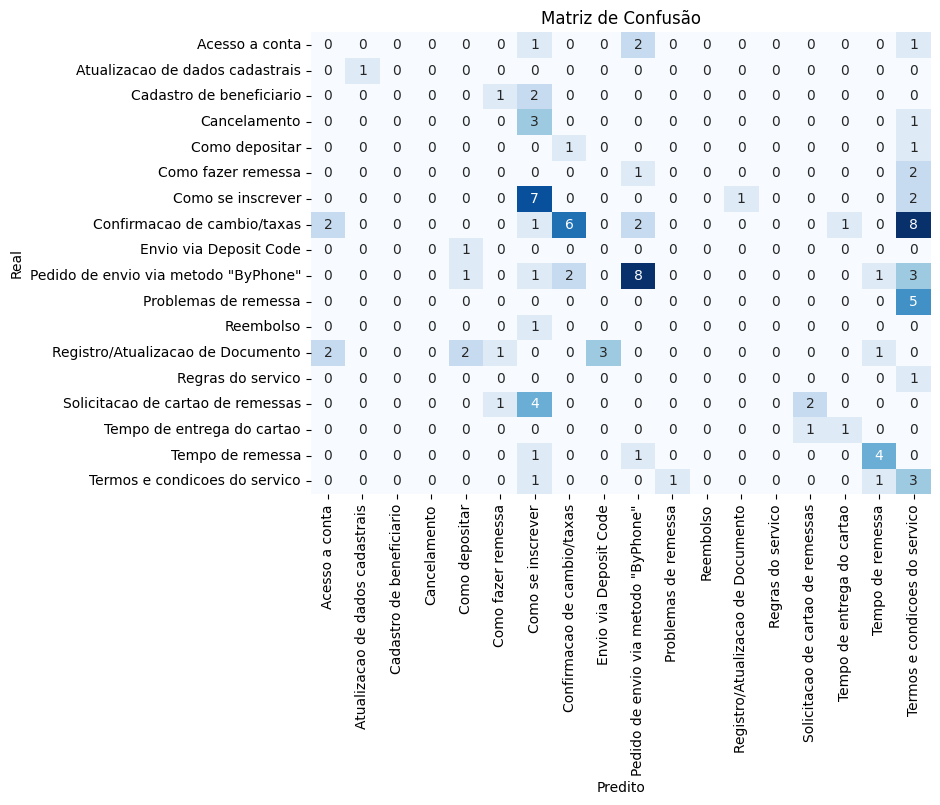

In [68]:
# Construindo a matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# 6. Análise CPU x GPU

In [19]:
root_dir = "/content/drive/MyDrive/Dados/"
try:
    with open(root_dir + "execution_times_pre.json", "r") as f:
        data = json.load(f)
except FileNotFoundError:
    data = {}

In [20]:
def memory_usage_psutil():
    """
        Returns the memory usage of the process in MB
    """
    try:
      process = psutil.Process()
      mem = process.memory_info().rss / float(2 ** 20)  # em MB
      return mem
    except Exception as e:
        print(f"Erro ao calcular a memória: {e}")
        raise

## 6.1 CPU

In [21]:
num_samples = 5

all_times = 0
all_mem = 0

for i in range(num_samples):
    cpu_model = model

    cpu_start_time = time.time()
    cpu_start_mem = memory_usage_psutil()

    cpu_model.fit(X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1), y_train_smote, epochs=100, batch_size=32, validation_split=0.2)
    y_pred_cpu = cpu_model.predict(X_test)

    cpu_mem = memory_usage_psutil() - cpu_start_mem

    cpu_time = time.time() - cpu_start_time

    all_times += cpu_time
    all_mem += cpu_mem

cpu_time = all_times / num_samples
cpu_mem = all_mem / num_samples

data["CPU"] = {
    "execution_time": cpu_time,
    "memory_usage": cpu_mem
}

with open(root_dir + "execution_times_pre.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 502ms/step - accuracy: 0.1946 - loss: 2.7039 - val_accuracy: 0.0000e+00 - val_loss: 3.0068
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 493ms/step - accuracy: 0.3291 - loss: 2.3527 - val_accuracy: 0.0000e+00 - val_loss: 3.0533
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accuracy: 0.3962 - loss: 2.0596 - val_accuracy: 0.0000e+00 - val_loss: 3.1088
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 480ms/step - accuracy: 0.4107 - loss: 2.0341 - val_accuracy: 0.0000e+00 - val_loss: 3.1564
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 472ms/step - accuracy: 0.4659 - loss: 1.8101 - val_accuracy: 0.0000e+00 - val_loss: 3.2749
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.4655 - loss: 1.8266 - val_accuracy: 0.0000e+00 - val_loss: 3.4630
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 480ms/step - accuracy: 0.4900 - loss: 1.6740 - val_accuracy: 0.0000e+00 - val_loss: 3.3316
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accura

## 6.2 T4 GPU

In [21]:
num_samples = 5

all_times = 0
all_mem = 0

for i in range(num_samples):
    t4_model = model

    t4_start_time = time.time()
    t4_start_mem = memory_usage_psutil()

    t4_model.fit(X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1), y_train_smote, epochs=100, batch_size=32, validation_split=0.2)
    y_pred_t4 = t4_model.predict(X_test)

    t4_mem = memory_usage_psutil() - t4_start_mem

    t4_time = time.time() - t4_start_time
    all_times += t4_time
    all_mem += t4_mem

t4_time = all_times / num_samples
t4_mem = all_mem / num_samples

data["T4 GPU"] = {
    "execution_time": t4_time,
    "memory_usage": t4_mem
}

with open(root_dir + "execution_times_pre.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.1813 - loss: 2.7417 - val_accuracy: 0.0178 - val_loss: 2.9468
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.2994 - loss: 2.3435 - val_accuracy: 0.0000e+00 - val_loss: 2.9377
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3884 - loss: 2.0795 - val_accuracy: 0.0000e+00 - val_loss: 2.9501
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4560 - loss: 1.8895 - val_accuracy: 0.0000e+00 - val_loss: 3.0115
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4347 - loss: 1.8714 - val_accuracy: 0.0000e+00 - val_loss: 2.9895
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4860 - loss: 1.7131 - val_accuracy: 0.0000e+00 - val_loss: 3.2609
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4946 - loss: 1.6777 - val_accuracy: 0.0000e+00 - val_loss: 3.1955
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5406 - loss: 1

## 6.3 A100 GPU

In [21]:
num_samples = 5

all_times = 0
all_mem = 0

for i in range(num_samples):
    a100_model = model

    a100_start_time = time.time()
    a100_start_mem = memory_usage_psutil()

    a100_model.fit(X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1), y_train_smote, epochs=100, batch_size=32, validation_split=0.2)
    y_pred_a100 = a100_model.predict(X_test)

    a100_mem = memory_usage_psutil() - a100_start_mem

    a100_time = time.time() - a100_start_time
    all_times += a100_time
    all_mem += a100_mem

a100_time = all_times / num_samples
a100_mem = all_mem / num_samples

data["A100 GPU"] = {
    "execution_time": a100_time,
    "memory_usage": a100_mem
}

with open(root_dir + "execution_times_pre.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.1777 - loss: 2.7968 - val_accuracy: 0.0000e+00 - val_loss: 2.9985
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.2920 - loss: 2.3842 - val_accuracy: 0.0000e+00 - val_loss: 3.0406
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3908 - loss: 2.0063 - val_accuracy: 0.0000e+00 - val_loss: 3.0737
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4159 - loss: 1.8965 - val_accuracy: 0.0000e+00 - val_loss: 3.1480
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4238 - loss: 1.8633 - val_accuracy: 0.0000e+00 - val_loss: 3.1456
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5358 - loss: 1.5953 - val_accuracy: 0.0000e+00 - val_loss: 3.2845
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4940 - loss: 1.6710 - val_accuracy: 0.0000e+00 - val_loss: 3.4899
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5495 - los

## 6.4 Análise

### 6.4.1 Tempo de execução

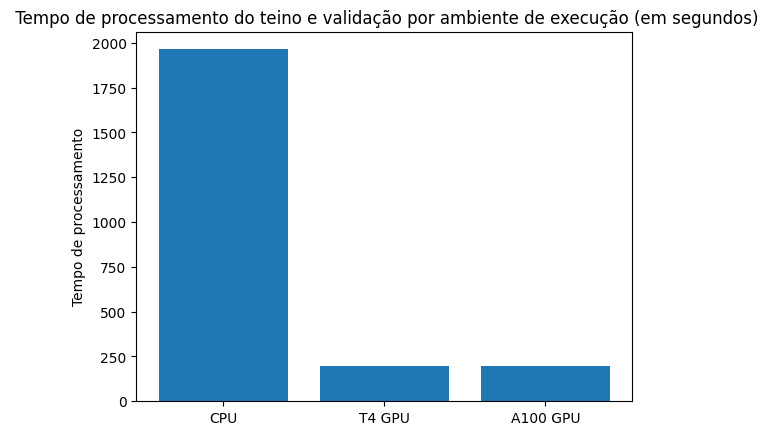

In [22]:
fig, ax = plt.subplots()

cpu_time = data["CPU"]["execution_time"]
t4_time = data["T4 GPU"]["execution_time"]
a100_time = data["A100 GPU"]["execution_time"]

shapes = [cpu_time, t4_time, a100_time]
labels = ["CPU", "T4 GPU", "A100 GPU"]

ax.bar(labels, [s for s in shapes])
ax.set_ylabel("Tempo de processamento")
ax.set_title(" Tempo de processamento do teino e validação por ambiente de execução (em segundos)")

plt.show()

É possível notar que a CPU apresentou um tempo de processamento muito maior, em uma média de 5 experimentos, se comparado as GPUs. Isso indica que é muito mais otimizado realizar o treinamento utilizando GPUs.

### 6.4.2 Uso de memória

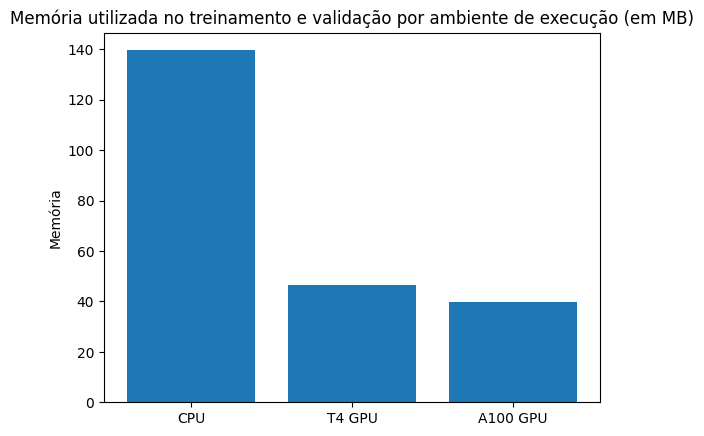

In [23]:
fig, ax = plt.subplots()

cpu_mem = data["CPU"]["memory_usage"]
t4_mem = data["T4 GPU"]["memory_usage"]
a100_mem = data["A100 GPU"]["memory_usage"]

shapes = [cpu_mem, t4_mem, a100_mem]
labels = ["CPU", "T4 GPU", "A100 GPU"]

ax.bar(labels, [s for s in shapes])
ax.set_ylabel("Memória")
ax.set_title("Memória utilizada no treinamento e validação por ambiente de execução (em MB)")

plt.show()

É possível notar que a CPU apresentou um uso de memória muito maior, em uma média de 5 experimentos, se comparado as GPUs. Essa informação também indica que é muito mais otimizado realizar o treinamento utilizando GPUs.